In [1]:
import pandas as pd
import altair as alt
import networkx as nx
import matplotlib.pyplot as plt
import math

# Exploring the wireshark data

### To best visualize the data, first let's do some data exploration. We first have to read in the csv file, do some data cleaning, and do simple queries to explore the data.

Let's read in the csv files and convert them into pandas dataframes

In [2]:
packet_df = pd.read_csv('no-mitm.csv', encoding = "ISO-8859-1")
print(packet_df.tail())
mitm_df = pd.read_csv('mitm.csv', encoding = "ISO-8859-1")

       No.        Time             Source        Destination Protocol  Length  \
6676  6677  121.495005     192.168.88.254     35.153.239.229      TCP      66   
6677  6678  121.612625     192.168.88.254     35.153.239.229  TLSv1.2     192   
6678  6679  121.635766     35.153.239.229     192.168.88.254  TLSv1.2     324   
6679  6680  121.772408  b8:69:f4:75:d3:a1  ff:ff:ff:ff:ff:ff      ARP      60   
6680  6681  122.789876  b8:69:f4:75:d3:a1  ff:ff:ff:ff:ff:ff      ARP      60   

                                                   Info  
6676  41432  >  443 [ACK] Seq=182 Ack=5241 Win=99328...  
6677  Client Key Exchange, Change Cipher Spec, Encry...  
6678  New Session Ticket, Change Cipher Spec, Encryp...  
6679          Who has 192.168.88.237? Tell 192.168.88.1  
6680          Who has 192.168.88.237? Tell 192.168.88.1  


### Let's look at the devices emitting traffic and traffic count

In [3]:
print(packet_df.Source.unique())
print(len(packet_df.Source.unique()))

['b8:69:f4:75:d3:a1' '04:95:e6:22:f8:61' '176.32.101.52' '192.168.88.239'
 '192.168.88.254' '192.168.88.1' '52.119.197.108' '90:a8:22:04:73:81'
 '88:d7:f6:77:66:72' '35.190.88.7' '157.240.220.16' '18.214.249.225'
 '40.84.20.120' '44.239.16.243' '35.244.137.38' '34.235.172.61'
 '192.168.88.253' '192.168.88.236' '23.33.242.16' '52.94.243.192'
 '3.87.130.43' 'dc:4f:22:27:83:c4' '52.1.211.0' '142.251.45.106'
 'fe80::8ad7:f6ff:fe77:6672' '0.0.0.0' '192.168.88.238' '52.94.233.103'
 '52.46.142.109' '162.115.24.30' '35.153.239.229']
31


Wow, that's a lot more unique entries than devices that we're expecting! Because our data is static, we can do some data relabelling to match MAC and IP addresses to the actual device. Note: Because of DHCP, with new data, the IP address lookup may not work. 

In [4]:
reference_dict = {'192.168.88.254': 'asus', '88:d7:f6:77:66:72': 'asus', 
                 '192.168.88.239': 'alexa', '90:a8:22:04:73:81' : 'alexa',
                  '192.168.88.238': 'pi_target', 'b8:27:eb:84:8a:84': 'pi_target',
                  '192.168.88.234' : 'pi_mitm', 'b8:27:eb:22:a0:16': 'pi_mitm', 
                  'b8:27:eb:ab:e3:ea' :'pi_extra',
                  '192.168.88.253': 'smartplug', 'dc:4f:22:27:83:c4': 'smartplug',
                  '192.168.88.236': 'tenda', '04:95:e6:22:f8:61' : 'tenda',
                  '192.168.88.1': 'mikrotik', 'b8:69:f4:75:d3:a1': 'mikrotik'
                 }

packet_df = packet_df.replace(reference_dict)
mitm_df = mitm_df.replace(reference_dict)

Now let's look at the unique values and counts for the Source column and Destination column

In [5]:
packet_df.Source.value_counts()


asus                         2001
alexa                        1652
176.32.101.52                1587
52.94.233.103                 777
mikrotik                      150
18.214.249.225                133
34.235.172.61                  95
tenda                          70
smartplug                      34
52.119.197.108                 22
35.190.88.7                    20
52.94.243.192                  19
44.239.16.243                  17
40.84.20.120                   17
52.46.142.109                  14
157.240.220.16                 13
52.1.211.0                     12
142.251.45.106                 12
35.153.239.229                  9
35.244.137.38                   9
23.33.242.16                    6
3.87.130.43                     4
162.115.24.30                   4
pi_target                       2
fe80::8ad7:f6ff:fe77:6672       1
0.0.0.0                         1
Name: Source, dtype: int64

In [6]:
packet_df.Destination.value_counts()

52.94.233.103        1697
176.32.101.52        1621
alexa                1614
asus                 1074
ff:ff:ff:ff:ff:ff     123
18.214.249.225        118
smartplug              97
01:80:c2:00:00:00      61
34.235.172.61          32
mikrotik               23
52.119.197.108         22
35.190.88.7            22
52.94.243.192          21
40.84.20.120           19
44.239.16.243          19
52.1.211.0             17
52.46.142.109          15
157.240.220.16         14
35.153.239.229         11
142.251.45.106         11
35.244.137.38          10
tenda                   8
3.87.130.43             6
23.33.242.16            6
162.115.24.30           5
172.217.2.110           3
142.250.65.228          2
01:00:0c:cc:cc:cc       2
255.255.255.255         2
ff02::2                 1
224.0.0.106             1
224.0.0.251             1
239.255.255.250         1
224.0.0.1               1
142.250.72.99           1
Name: Destination, dtype: int64

### We can also look at how much traffic there is separated by protocol by creating simple barcharts, using built in matplotlib function. 

Matplotlib is a library that creates Matlab like visualizations in python

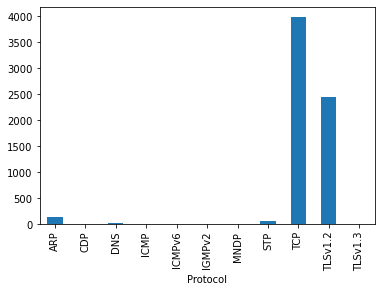

In [7]:
packet_protocol_df = packet_df.groupby('Protocol').Source.count()
packet_protocol_df.plot(kind='bar')

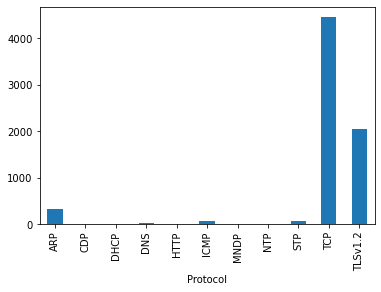

In [8]:
mitm_protocol_df = mitm_df.groupby('Protocol').Source.count()
mitm_protocol_df.plot(kind='bar')

Now we're going to visualize the traffic over time using Altair. 

In [9]:
def alt_traffic(df):
    max_index = len(df.index) -1
    max_time = df.Time[max_index]

    alt.data_transformers.disable_max_rows()

    chart = alt.Chart(packet_df, title='Initial traffic vs time visualization').mark_bar().encode(
        alt.X("Time", bin = alt.Bin(maxbins=max_time)),
        y='count()'
    )
    chart.display()

In [10]:
alt_traffic(packet_df)

alt.Chart(...)

In [11]:
alt_traffic(mitm_df)

alt.Chart(...)

If we want to do our own binning in the dataframe and verify our initial visualization, we can do a quick pandas manipulation.

In [12]:
def hand_binning(df):
    counter = 0
    packet_count = {}
    for index, row in df.iterrows():
        if row['Time'] > counter:
            counter += 1
        packet_count[counter] = packet_count.get(counter, 0) + 1

    pkt_count_df = pd.DataFrame.from_dict(packet_count, orient='index', columns=['traffic_count'])
    pkt_count_df['seconds'] = pkt_count_df.index.copy()
    chart = alt.Chart(pkt_count_df, title='Traffic vs. Time (manual binning)').mark_bar().encode(
        x= 'seconds',
        y='traffic_count',
    )
    chart.display()

In [13]:
hand_binning(packet_df)

alt.Chart(...)

In [14]:
hand_binning(mitm_df)

alt.Chart(...)

Now that we've created a basic traffic data, let's see if we can create a network visualization with connections between nodes that we've observed in our wireshark data. We use the library networkx for this, as it's a visualizaiton tool for making standard network graphs in Python.

In [15]:
def connection_graph_df(df):    
    #Creating edge weights
    source_dest_index = {}
    source_dest_count = {'Source' : [], 'Destination': [], 'Count': []}
    counter = 0
    #go through source and destination pairs?
    for index, row in df.iterrows():
        source = row['Source']
        destination = row['Destination']
        if (source, destination) in source_dest_index:
            count_index = source_dest_index[(source, destination)]
            source_dest_count['Count'][count_index] += 1
        else:
            source_dest_index[(source, destination)] = counter
            source_dest_count['Source'].append(source)
            source_dest_count['Destination'].append(destination)
            source_dest_count['Count'].append(1)
            counter += 1
    
    source_dest_count['Weight'] = [i for i in source_dest_count['Count']]

    traffic_edge_df = pd.DataFrame.from_dict(source_dest_count)
    sorted_traffic_edge_df = traffic_edge_df.sort_values(by = ['Source', 'Count'])
    
    return sorted_traffic_edge_df

def networkx_connection(df):
    G = nx.from_pandas_edgelist(df, 'Source', 'Destination', 'Weight', create_using=nx.DiGraph())

    pos = nx.circular_layout(G)

    edges = G.edges()
    weights = [math.log(G[u][v]['Weight']) for u,v in edges]

    plt.figure(3,figsize=(12,12)) 
    colors = range(20)
    nx.draw(G, pos, edge_color = 'orange', with_labels = True, width=weights)
#     nx.draw(G, pos, edges=edges, edge_color = 'yellow', width=weights, with_labels = True)
    plt.show()

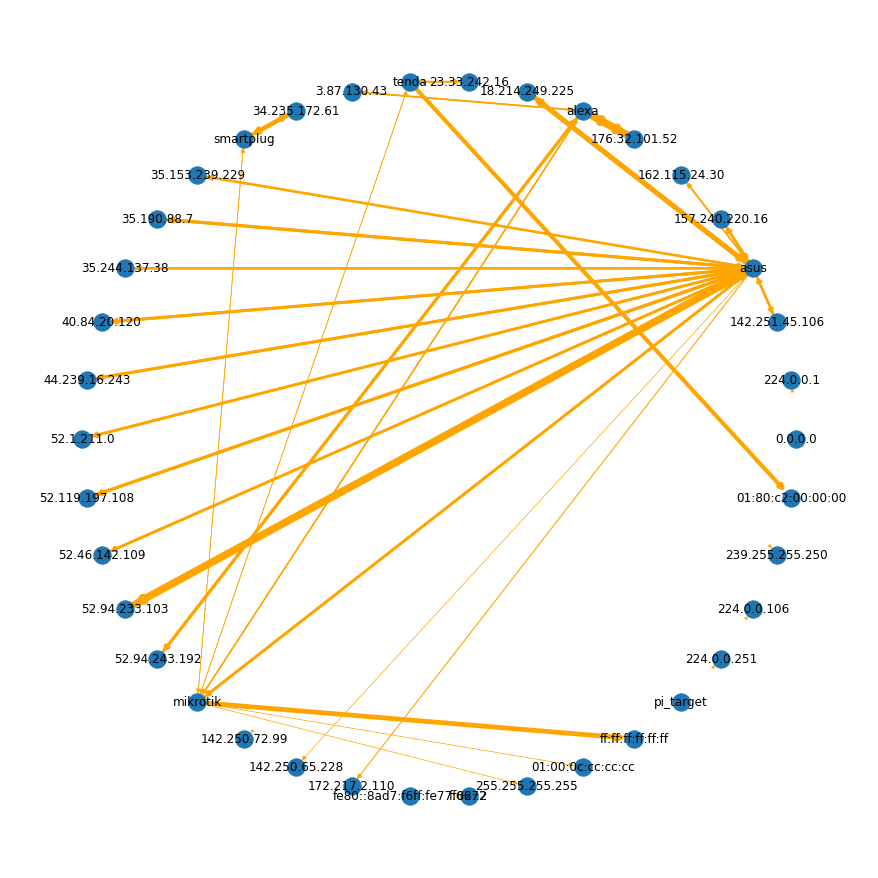

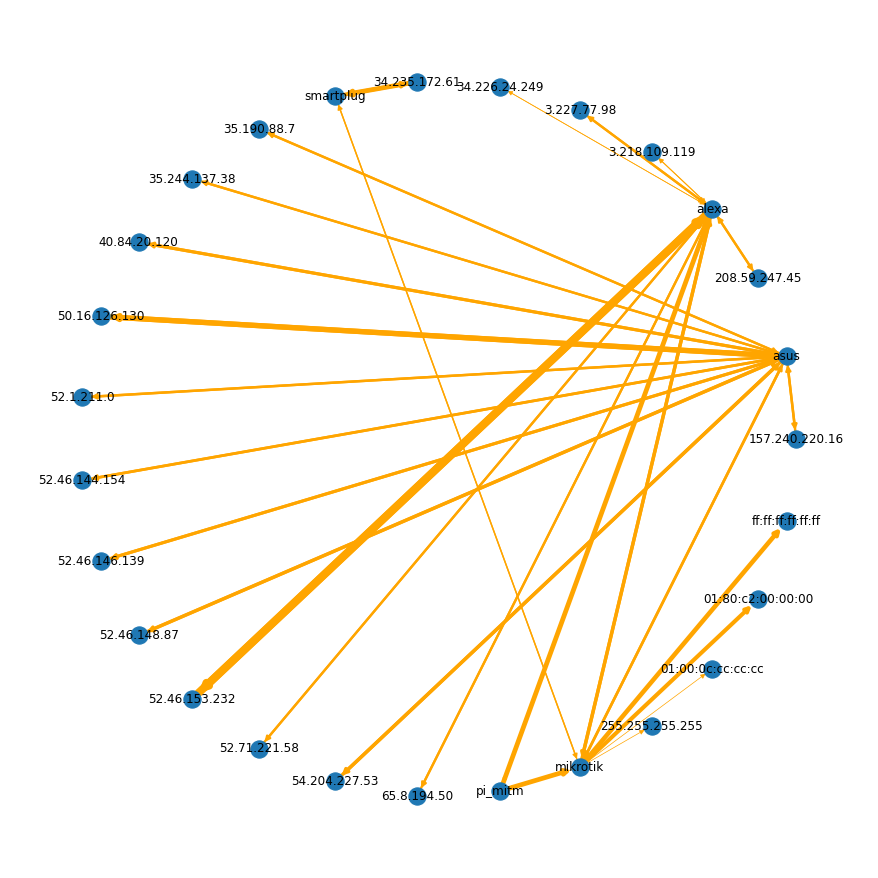

In [16]:
packet_conn_df= connection_graph_df(packet_df)
mitm_conn_df = connection_graph_df(mitm_df)
networkx_connection(packet_conn_df)
networkx_connection(mitm_conn_df)